# Semester 1 Project Submission
- Adam Burstyn
- Nick/Julian

This notebook contains the code to explore the tables provided for the movie information

In [1]:
import pandas as pd
import sqlite3
import re
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
%matplotlib inline
from helper_functions import *

## Explore links to combine tables

### Load tables from data scources

In [2]:
# load tables from the sql db

# connect  to db
conn = sqlite3.connect("../Data/im.db")

# load movie basics table
movie_basics_df = pd.read_sql("SELECT * FROM movie_basics;", conn)

# load movie ratings table
movie_ratings_df = pd.read_sql("SELECT * FROM movie_ratings;", conn)

# load movie aka table
movie_akas_df = pd.read_sql("SELECT * FROM movie_akas;", conn)

### Load data from files

In [3]:
# load movie gross data
movie_gross = pd.read_csv("../Data/bom.movie_gross.csv")

# load movie budget/gross data
movie_budgets = pd.read_csv("../Data/tn.movie_budgets.csv")

### Preview tables

In [4]:
movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [5]:
movie_gross

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


In [6]:
movie_basics_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [7]:
movie_ratings_df

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


* only about half of the movies have ratings, is it worth exploring an algorithm to impute the missing ratings?

In [8]:
movie_akas_df

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0
...,...,...,...,...,...,...,...,...
331698,tt9827784,2,Sayonara kuchibiru,None,None,original,None,1.0
331699,tt9827784,3,Farewell Song,XWW,en,imdbDisplay,None,0.0
331700,tt9880178,1,La atención,None,None,original,None,1.0
331701,tt9880178,2,La atención,ES,None,None,None,0.0


### Combine SQL tables

In [9]:
# join tables on movie_id
df = movie_ratings_df.merge(movie_basics_df, how="inner", on="movie_id")
df = df.merge(movie_akas_df, how="inner", on="movie_id")
df

,movie_id,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,ordering,title,region,language,types,attributes,is_original_title
0,tt1042974,6.4,20,Just Inès,Just Inès,2010,90.0,Drama,1,Just Inès,None,None,original,None,1.0
1,tt1042974,6.4,20,Just Inès,Just Inès,2010,90.0,Drama,2,Samo Ines,RS,None,imdbDisplay,None,0.0
2,tt1042974,6.4,20,Just Inès,Just Inès,2010,90.0,Drama,3,Just Inès,GB,None,None,None,0.0
3,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",10,The Legend of Hercules,None,None,original,None,1.0
4,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",11,Hércules - A Lenda Começa,PT,None,imdbDisplay,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261801,tt9691896,6.3,21,Out,Coming Out,2018,64.0,Documentary,4,Coming Out,None,None,original,None,1.0
261802,tt9844256,7.5,24,Code Geass: Lelouch of the Rebellion - Glorifi...,Code Geass: Lelouch of the Rebellion Episode III,2018,120.0,"Action,Animation,Sci-Fi",1,Code Geass: Lelouch of the Rebellion Episode III,JP,None,None,None,0.0
261803,tt9844256,7.5,24,Code Geass: Lelouch of the Rebellion - Glorifi...,Code Geass: Lelouch of the Rebellion Episode III,2018,120.0,"Action,Animation,Sci-Fi",2,Code Geass: Lelouch of the Rebellion Episode III,None,None,original,None,1.0
261804,tt9844256,7.5,24,Code Geass: Lelouch of the Rebellion - Glorifi...,Code Geass: Lelouch of the Rebellion Episode III,2018,120.0,"Action,Animation,Sci-Fi",3,Code Geass: Lelouch of the Rebellion - Glorifi...,XWW,en,imdbDisplay,None,0.0


### Keep only US movies

In [10]:
# find the tag for US region
df["region"].unique()

array([None, 'RS', 'GB', 'PT', 'JP', 'AL', 'HR', 'VN', 'IT', 'GR', 'UA',
       'RO', 'US', 'CA', 'CL', 'MX', 'RU', 'TR', 'IL', 'AR', 'PE', 'FR',
       'ES', 'BR', 'PL', 'BG', 'HU', 'VE', 'SE', 'XWW', 'XEU', 'SI', 'UY',
       'FI', 'DE', 'PH', 'NO', 'DK', 'EE', 'BE', 'LT', 'CO', 'CZ', 'AT',
       'GE', 'IE', 'ZA', 'BA', 'LV', 'AU', 'LU', 'IN', 'KR', 'IR', 'NL',
       'DZ', 'CN', 'NZ', 'ID', 'MY', 'JO', 'RW', 'EG', 'CH', 'LI', 'TH',
       'BF', 'CSXX', 'SG', 'NP', 'SK', 'BD', 'PA', 'KE', 'PK', 'PS', 'HK',
       'MK', 'KZ', 'TW', 'LK', 'IS', 'MW', 'DO', 'BO', 'PY', 'SL', 'AZ',
       'AF', 'AE', 'PR', 'CU', 'NG', 'IQ', 'AM', 'CY', 'GU', 'HN', 'XAS',
       'TN', 'BY', 'SA', 'HT', 'MT', 'BH', 'KH', 'KG', 'FO', 'SV', 'XSA',
       'GT', 'LB', 'BT', 'CR', 'XKV', 'UZ', 'MA', 'ME', 'LA', 'SB', 'XKO',
       'SY', 'TZ', 'QA', 'MN', 'EC', 'JM', 'NE', 'AN', 'MV', 'TT', 'ET',
       'CF', 'CM', 'MM', 'TJ', 'SM', 'MD', 'GW', 'KW', 'AD', 'BB', 'MZ',
       'BS', 'SO', 'BZ', 'IM', 'MC', 'AW', 

region is US as this is a US based company

In [11]:
us_movies = df[df["region"]=="US"]
us_movies

,movie_id,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,ordering,title,region,language,types,attributes,is_original_title
14,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",20,The Legend of Hercules,US,None,None,None,0.0
26,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",31,Untitled Hercules Project,US,None,working,None,0.0
29,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",5,Hercules: The Legend Begins,US,None,working,None,0.0
42,tt1094666,7.0,1613,The Hammer,Hamill,2010,108.0,"Biography,Drama,Sport",4,Hamill,US,None,festival,None,0.0
45,tt1094666,7.0,1613,The Hammer,Hamill,2010,108.0,"Biography,Drama,Sport",7,The Hammer,US,None,imdbDisplay,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261737,tt9165332,7.4,710,Chitralahari,Chitralahari,2019,131.0,Drama,2,Chitralahari,US,en,imdbDisplay,None,0.0
261760,tt9382596,4.1,293,The Car: Road to Revenge,The Car: Road to Revenge,2019,89.0,"Action,Horror,Thriller",1,The Car 2: Road to Revenge,US,None,working,None,0.0
261761,tt9382596,4.1,293,The Car: Road to Revenge,The Car: Road to Revenge,2019,89.0,"Action,Horror,Thriller",2,The Car 2,US,None,working,None,0.0
261762,tt9382596,4.1,293,The Car: Road to Revenge,The Car: Road to Revenge,2019,89.0,"Action,Horror,Thriller",3,The Car: Road to Revenge,US,None,None,None,0.0


In [12]:
us_movies["movie_id"].nunique()

26654

There are duplicate movie ids

In [13]:
# keep only 1 entry for each movie id
us_movies = us_movies.drop_duplicates(subset=["movie_id"])
us_movies

,movie_id,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,ordering,title,region,language,types,attributes,is_original_title
14,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",20,The Legend of Hercules,US,None,None,None,0.0
42,tt1094666,7.0,1613,The Hammer,Hamill,2010,108.0,"Biography,Drama,Sport",4,Hamill,US,None,festival,None,0.0
64,tt1161457,4.2,148,Vanquisher,The Vanquisher,2016,90.0,"Action,Adventure,Sci-Fi",1,Vanquisher,US,None,None,new title,0.0
76,tt1171222,5.1,8296,Baggage Claim,Baggage Claim,2013,96.0,Comedy,5,Baggage Claim,US,None,None,None,0.0
85,tt1174693,5.8,2381,The Four-Faced Liar,The Four-Faced Liar,2010,87.0,"Comedy,Drama,Romance",5,The Four-Faced Liar,US,None,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261715,tt8948790,9.0,1778,Jersey,Jersey,2019,157.0,"Drama,Sport",3,Jersey,US,en,imdbDisplay,None,0.0
261734,tt9127488,9.3,10,Postal,Postal,2019,77.0,Comedy,2,Postal,US,None,None,None,0.0
261737,tt9165332,7.4,710,Chitralahari,Chitralahari,2019,131.0,Drama,2,Chitralahari,US,en,imdbDisplay,None,0.0
261760,tt9382596,4.1,293,The Car: Road to Revenge,The Car: Road to Revenge,2019,89.0,"Action,Horror,Thriller",1,The Car 2: Road to Revenge,US,None,working,None,0.0


### Add in gross numbers

#### Clean movie title and year info for merging
- use primary title as title
- all lowercase
- keep only alpha-numeric values
- remove spaces
    - to eliminate issues with titles contaning "Star Wars:Episode 3" vs "Star Wars: Episode 3"

** We will merge on title and year to differentiate between movies with the same title relseased in different year (remakes)

In [14]:
# use RegEx to keep only alpha-numeric values, remove spaces and make all letters lowercase 
#us_movies["title"] = us_movies["title"].map(lambda x: re.sub(r'[^A-Za-z0-9 ]+', '', x).lower())
us_movies["title"] = us_movies["primary_title"]

us_movies["title"] = us_movies["title"].map(lambda x: re.sub(r'[^A-Za-z0-9]+', '', x).lower())
movie_budgets["movie"] = movie_budgets["movie"].map(lambda x: re.sub(r'[^A-Za-z0-9]+', '', x).lower())
movie_gross["title"] = movie_gross["title"].map(lambda x: re.sub(r'[^A-Za-z0-9]+', '', x).lower())

<ipython-input-14-25be13c0b9d5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_movies["title"] = us_movies["primary_title"]
<ipython-input-14-25be13c0b9d5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_movies["title"] = us_movies["title"].map(lambda x: re.sub(r'[^A-Za-z0-9]+', '', x).lower())


In [15]:
# get a year column as int to match other df data types
movie_budgets["year"] = movie_budgets["release_date"].map(lambda x: int(x[-4:]))
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year
0,1,"Dec 18, 2009",avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009
1,2,"May 20, 2011",piratesofthecaribbeanonstrangertides,"$410,600,000","$241,063,875","$1,045,663,875",2011
2,3,"Jun 7, 2019",darkphoenix,"$350,000,000","$42,762,350","$149,762,350",2019
3,4,"May 1, 2015",avengersageofultron,"$330,600,000","$459,005,868","$1,403,013,963",2015
4,5,"Dec 15, 2017",starwarsepviiithelastjedi,"$317,000,000","$620,181,382","$1,316,721,747",2017


In [16]:
# rename columns to match for merging
movie_budgets.rename(columns={"movie": "title", "domestic_gross": "domestic_gross_movie_budgets",
                              "worldwide_gross": "worldwide_gross_movie_budgets"}, inplace=True)

movie_gross.rename(columns={"domestic_gross": "domestic_gross_movie_gross", 
                            "foreign_gross": "foreign_gross_movie_gross"}, inplace=True)

us_movies.rename(columns={"start_year": "year"}, inplace=True)

<ipython-input-16-8e52a97c0efb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_movies.rename(columns={"start_year": "year"}, inplace=True)


#### Merge dataframes to get all gross revenue info

In [17]:
final_gross_df1 = us_movies.merge(movie_budgets, on=["title", "year"], how="inner")#.drop_duplicates(subset=["movie_id"])
len(final_gross_df1), final_gross_df1["movie_id"].nunique()

(1412, 1412)

In [18]:
final_gross_df1.head()

,movie_id,averagerating,numvotes,primary_title,original_title,year,runtime_minutes,genres,ordering,title,region,language,types,attributes,is_original_title,id,release_date,production_budget,domestic_gross_movie_budgets,worldwide_gross_movie_budgets
0,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",20,thelegendofhercules,US,None,None,None,0.0,42,"Jan 10, 2014","$70,000,000","$18,848,538","$58,953,319"
1,tt1171222,5.1,8296,Baggage Claim,Baggage Claim,2013,96.0,Comedy,5,baggageclaim,US,None,None,None,0.0,38,"Sep 27, 2013","$8,500,000","$21,569,509","$22,885,836"
2,tt1210166,7.6,326657,Moneyball,Moneyball,2011,133.0,"Biography,Drama,Sport",14,moneyball,US,None,imdbDisplay,None,0.0,15,"Sep 23, 2011","$50,000,000","$75,605,492","$111,300,835"
3,tt1212419,6.5,87288,Hereafter,Hereafter,2010,129.0,"Drama,Fantasy,Romance",4,hereafter,US,None,None,None,0.0,61,"Oct 15, 2010","$50,000,000","$32,746,941","$108,660,270"
4,tt1229238,7.4,428142,Mission: Impossible - Ghost Protocol,Mission: Impossible - Ghost Protocol,2011,132.0,"Action,Adventure,Thriller",11,missionimpossibleghostprotocol,US,None,working,None,0.0,98,"Dec 16, 2011","$145,000,000","$209,397,903","$694,713,230"


In [19]:
final_gross_df2 = us_movies.merge(movie_gross, on=["title", "year"], how="inner")#.drop_duplicates(subset=["movie_id"])
len(final_gross_df2), final_gross_df2["movie_id"].nunique()

(1437, 1437)

In [20]:
final_gross_df2.head()

,movie_id,averagerating,numvotes,primary_title,original_title,year,runtime_minutes,genres,ordering,title,region,language,types,attributes,is_original_title,studio,domestic_gross_movie_gross,foreign_gross_movie_gross
0,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",20,thelegendofhercules,US,None,None,None,0.0,LG/S,18800000.0,42400000
1,tt1171222,5.1,8296,Baggage Claim,Baggage Claim,2013,96.0,Comedy,5,baggageclaim,US,None,None,None,0.0,FoxS,21600000.0,887000
2,tt1210166,7.6,326657,Moneyball,Moneyball,2011,133.0,"Biography,Drama,Sport",14,moneyball,US,None,imdbDisplay,None,0.0,Sony,75600000.0,34600000
3,tt1212419,6.5,87288,Hereafter,Hereafter,2010,129.0,"Drama,Fantasy,Romance",4,hereafter,US,None,None,None,0.0,WB,32700000.0,72500000
4,tt1229238,7.4,428142,Mission: Impossible - Ghost Protocol,Mission: Impossible - Ghost Protocol,2011,132.0,"Action,Adventure,Thriller",11,missionimpossibleghostprotocol,US,None,working,None,0.0,Par.,209400000.0,485300000


In [21]:
# concatenate the dataframes to contain records from both gross and budget dataframes
final_gross_all = pd.concat([final_gross_df1, final_gross_df2]).drop_duplicates(subset=["movie_id"])
len(final_gross_all), final_gross_all["movie_id"].nunique()

(1818, 1818)

In [22]:
final_gross_all.head()

,movie_id,averagerating,numvotes,primary_title,original_title,year,runtime_minutes,genres,ordering,title,...,attributes,is_original_title,id,release_date,production_budget,domestic_gross_movie_budgets,worldwide_gross_movie_budgets,studio,domestic_gross_movie_gross,foreign_gross_movie_gross
0,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",20,thelegendofhercules,...,None,0.0,42.0,"Jan 10, 2014","$70,000,000","$18,848,538","$58,953,319",NaN,NaN,NaN
1,tt1171222,5.1,8296,Baggage Claim,Baggage Claim,2013,96.0,Comedy,5,baggageclaim,...,None,0.0,38.0,"Sep 27, 2013","$8,500,000","$21,569,509","$22,885,836",NaN,NaN,NaN
2,tt1210166,7.6,326657,Moneyball,Moneyball,2011,133.0,"Biography,Drama,Sport",14,moneyball,...,None,0.0,15.0,"Sep 23, 2011","$50,000,000","$75,605,492","$111,300,835",NaN,NaN,NaN
3,tt1212419,6.5,87288,Hereafter,Hereafter,2010,129.0,"Drama,Fantasy,Romance",4,hereafter,...,None,0.0,61.0,"Oct 15, 2010","$50,000,000","$32,746,941","$108,660,270",NaN,NaN,NaN
4,tt1229238,7.4,428142,Mission: Impossible - Ghost Protocol,Mission: Impossible - Ghost Protocol,2011,132.0,"Action,Adventure,Thriller",11,missionimpossibleghostprotocol,...,None,0.0,98.0,"Dec 16, 2011","$145,000,000","$209,397,903","$694,713,230",NaN,NaN,NaN


## View Data Visualizations

In [23]:
# get cleaned df the from helper function
total_movie_info = get_clean_df().drop_duplicates(subset=["movie_id"]).dropna(subset=["clean_domestic_gross", "clean_worldwide_gross"])
total_movie_info

,movie_id,averagerating,numvotes,primary_title,original_title,year,runtime_minutes,genres,ordering,title,...,id,release_date,production_budget,domestic_gross_movie_budgets,worldwide_gross_movie_budgets,studio,domestic_gross_movie_gross,foreign_gross_movie_gross,clean_domestic_gross,clean_worldwide_gross
0,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",20,thelegendofhercules,...,42.0,"Jan 10, 2014",70000000.0,18848538.0,58953319.0,NaN,NaN,NaN,18848538.0,58953319.0
1,tt1171222,5.1,8296,Baggage Claim,Baggage Claim,2013,96.0,Comedy,5,baggageclaim,...,38.0,"Sep 27, 2013",8500000.0,21569509.0,22885836.0,NaN,NaN,NaN,21569509.0,22885836.0
2,tt1210166,7.6,326657,Moneyball,Moneyball,2011,133.0,"Biography,Drama,Sport",14,moneyball,...,15.0,"Sep 23, 2011",50000000.0,75605492.0,111300835.0,NaN,NaN,NaN,75605492.0,111300835.0
3,tt1212419,6.5,87288,Hereafter,Hereafter,2010,129.0,"Drama,Fantasy,Romance",4,hereafter,...,61.0,"Oct 15, 2010",50000000.0,32746941.0,108660270.0,NaN,NaN,NaN,32746941.0,108660270.0
4,tt1232829,7.2,477771,21 Jump Street,21 Jump Street,2012,109.0,"Action,Comedy,Crime",26,21jumpstreet,...,44.0,"Mar 16, 2012",42000000.0,138447667.0,202812429.0,NaN,NaN,NaN,138447667.0,202812429.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,tt0975645,6.8,68315,Hitchcock,Hitchcock,2012,98.0,"Biography,Comedy,Drama",12,hitchcock,...,NaN,NaN,NaN,NaN,NaN,FoxS,6000000.0,17600000.0,6000000.0,6000000.0
1054,tt2055765,5.8,11145,The English Teacher,The English Teacher,2013,93.0,"Comedy,Drama",19,theenglishteacher,...,NaN,NaN,NaN,NaN,NaN,Cdgm.,105000.0,NaN,105000.0,105000.0
1056,tt2132285,5.6,77726,The Bling Ring,The Bling Ring,2013,90.0,"Biography,Crime,Drama",1,theblingring,...,NaN,NaN,NaN,NaN,NaN,A24,5800000.0,13300000.0,5800000.0,5800000.0
1059,tt2463288,6.0,48134,Walk of Shame,Walk of Shame,2014,95.0,Comedy,12,walkofshame,...,NaN,NaN,NaN,NaN,NaN,FCW,59200.0,NaN,59200.0,59200.0


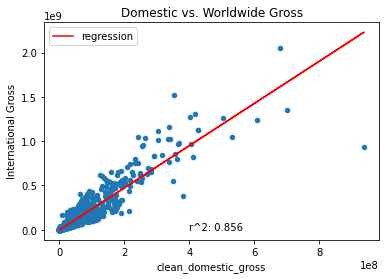

In [24]:
# investigate if there is there a relationship between domestic gross and foreign gross
ax = total_movie_info.plot(x="clean_domestic_gross", y="clean_worldwide_gross", kind="scatter",
                           title="Domestic vs. Worldwide Gross", xlabel="Domestic Gross", ylabel="International Gross")

# plot regression line
m = stats.linregress(total_movie_info["clean_domestic_gross"].to_list(), y=total_movie_info["clean_worldwide_gross"].to_list())
t = [m.slope * i + m.intercept for i in total_movie_info["clean_domestic_gross"]]

total_movie_info["regression"] = t

total_movie_info.plot.line(x="clean_domestic_gross", y="regression", color='r', ax=ax)
ax.annotate(f"r^2: {round(m.rvalue**2, 3)}", xy=(400000000, 1));

There is a very high correlation between domestic and international gross. Either variable will be sufficeint to use as a metric.

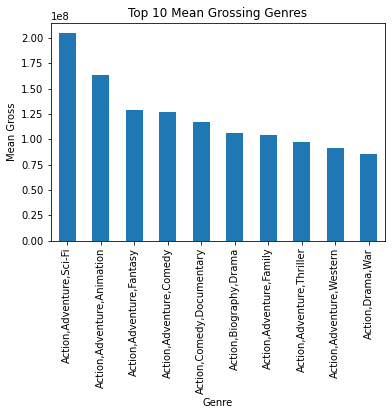

In [25]:
# find mean top revenue producing genres
counts = total_movie_info.groupby("genres").count()[["movie_id"]]
means = total_movie_info.groupby("genres").mean()[["clean_domestic_gross", "clean_worldwide_gross", "production_budget"]].head(50).sort_values("clean_domestic_gross", ascending=False)
top_genres = means.merge(counts, how="inner", on="genres").rename(columns={"movie_id": "num_movies"})

top_genres[["clean_domestic_gross"]].head(10).plot.bar(title="Top 10 Mean Grossing Genres",
                                                       ylabel="Mean Gross", xlabel="Genre", legend=False);

The "Action, Adventure, Sci-Fi" and "Action, Adventure, Animation" genres have the highest grossing means. Are they statistically higher than the other categories?

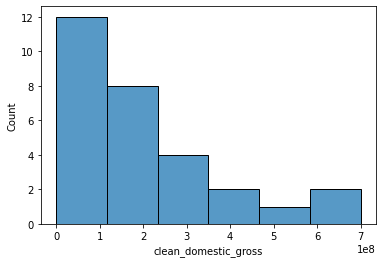

In [26]:
# view the distribution of the top genre
aascfi_df = total_movie_info[total_movie_info["genres"]=="Action,Adventure,Sci-Fi"]

#sns.distplot(aascfi_df["clean_domestic_gross"]);
sns.histplot(aascfi_df["clean_domestic_gross"]);

This distribution is right skewed. The lower end of the range may be more appropriate to investiage since it is skewed.

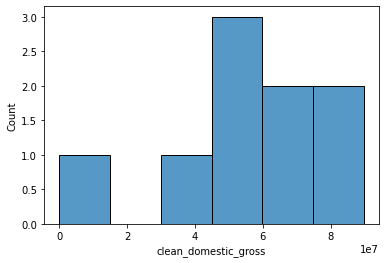

In [27]:
# further investigate lower end subset
aascfi_subset = aascfi_df[aascfi_df["clean_domestic_gross"]<=100000000]

sns.histplot(aascfi_subset["clean_domestic_gross"]);

This subset has a better distribution, but it is very limited in number of data points.

## Investigate merging Rotten Tomatoes Data

### Load data

In [28]:
# load RT data
rt_movie_info = pd.read_table("../Data/rt.movie_info.tsv")
rt_reviews = pd.read_table("../Data/rt.reviews.tsv", encoding = 'latin-1')

In [29]:
rt_movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [30]:
rt_reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


*There are multiple ratings for each movie, they will need to be averaged out if used

We will attempt to merge RT data with the other tables based on director and release date (highly unlikely that a producer released multiple movies on the same date)